# Model Comparison

This notebook compares the performance of **Linear Regression** and **CatBoost** models.

**Note**: Run `02_linear_regression.ipynb` and `03_catboost.ipynb` first to generate the results.

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 6)

## 1. Load Results

In [2]:
# Load results from both models
try:
    with open('results/linear_regression_results.pkl', 'rb') as f:
        linear_results = pickle.load(f)
    print("✓ Loaded Linear Regression results")
except FileNotFoundError:
    print("⚠ Linear Regression results not found. Please run 02_linear_regression.ipynb first.")
    linear_results = None

try:
    with open('results/catboost_results.pkl', 'rb') as f:
        catboost_results = pickle.load(f)
    print("✓ Loaded CatBoost results")
except FileNotFoundError:
    print("⚠ CatBoost results not found. Please run 03_catboost.ipynb first.")
    catboost_results = None

if linear_results is None or catboost_results is None:
    raise FileNotFoundError("Please run both model notebooks first!")

✓ Loaded Linear Regression results
✓ Loaded CatBoost results


## 2. Performance Comparison

In [3]:
# Create comparison dataframe
results_df = pd.DataFrame({
    'Linear Regression': linear_results['metrics'],
    'CatBoost': catboost_results['metrics']
}).T

print("Model Performance Comparison:")
print("=" * 60)
print(results_df.round(4))
print("\nBest Model by Metric:")
print(f"  Best R²: {results_df['R²'].idxmax()} ({results_df['R²'].max():.4f})")
print(f"  Best RMSE: {results_df['RMSE'].idxmin()} ({results_df['RMSE'].min():.2f})")
print(f"  Best MAE: {results_df['MAE'].idxmin()} ({results_df['MAE'].min():.2f})")
print(f"  Best MAPE: {results_df['MAPE'].idxmin()} ({results_df['MAPE'].min():.2f}%)")

Model Performance Comparison:
                       RMSE       MAE     MAPE      R²
Linear Regression  691.8504  532.1357  19.9869  0.3516
CatBoost           684.5557  520.7334  19.2872  0.3652

Best Model by Metric:
  Best R²: CatBoost (0.3652)
  Best RMSE: CatBoost (684.56)
  Best MAE: CatBoost (520.73)
  Best MAPE: CatBoost (19.29%)


## 3. Key Visualizations

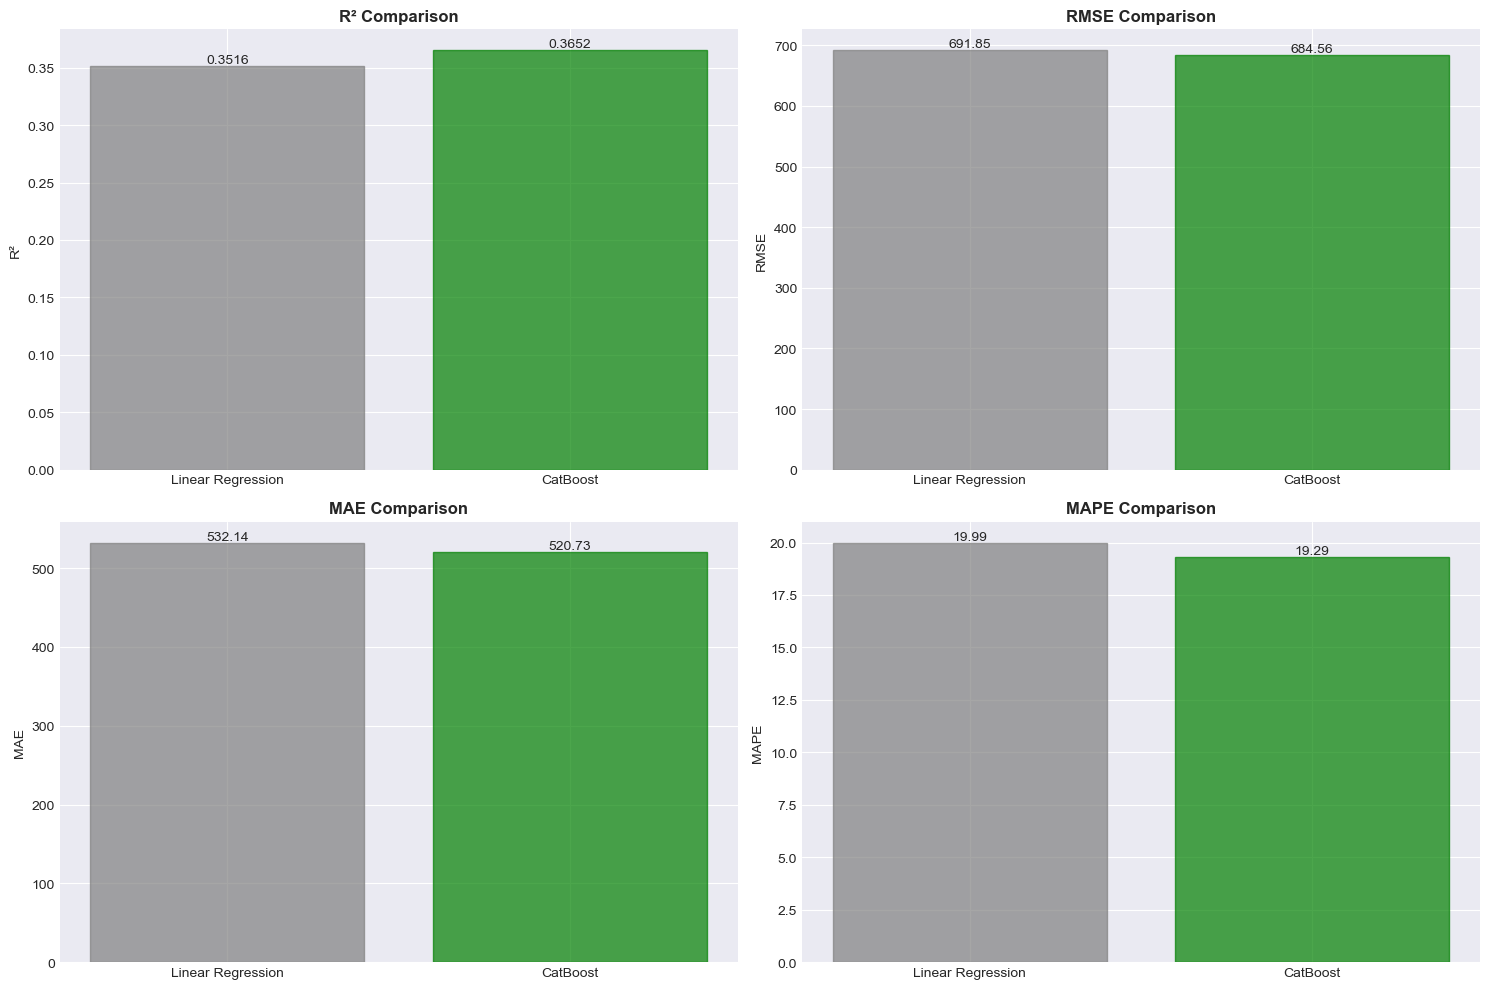

In [4]:
# Prepare data
y_test = np.array(linear_results['y_test'])
y_pred_linear = np.array(linear_results['predictions'])
y_pred_catboost = np.array(catboost_results['predictions'])
test_dates = pd.to_datetime(linear_results['test_dates'])

# 1. Metrics Comparison Bar Plot
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

metrics = ['R²', 'RMSE', 'MAE', 'MAPE']
for idx, metric in enumerate(metrics):
    ax = axes[idx // 2, idx % 2]
    values = [linear_results['metrics'][metric], catboost_results['metrics'][metric]]
    bars = ax.bar(['Linear Regression', 'CatBoost'], values, alpha=0.7)
    ax.set_title(f'{metric} Comparison', fontsize=12, fontweight='bold')
    ax.set_ylabel(metric)
    
    # Add value labels on bars
    for bar, val in zip(bars, values):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{val:.4f}' if metric == 'R²' else f'{val:.2f}',
                ha='center', va='bottom')
    
    # Highlight best (highest for R², lowest for others)
    if metric == 'R²':
        best_idx = np.argmax(values)
    else:
        best_idx = np.argmin(values)
    bars[best_idx].set_color('green')
    bars[1-best_idx].set_color('gray')

plt.tight_layout()
plt.show()

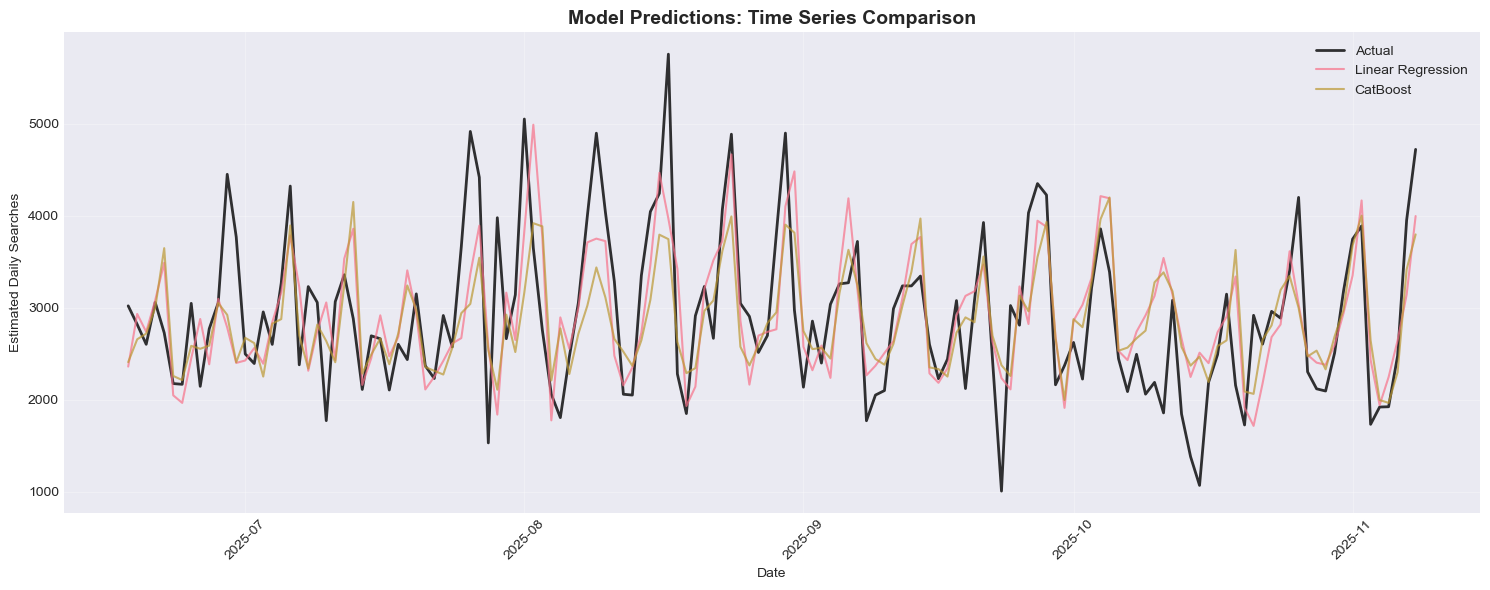

In [5]:
# 2. Time Series Comparison
fig, ax = plt.subplots(figsize=(15, 6))

ax.plot(test_dates, y_test, label='Actual', linewidth=2, alpha=0.8, color='black')
ax.plot(test_dates, y_pred_linear, label='Linear Regression', linewidth=1.5, alpha=0.7)
ax.plot(test_dates, y_pred_catboost, label='CatBoost', linewidth=1.5, alpha=0.7)

ax.set_title('Model Predictions: Time Series Comparison', fontsize=14, fontweight='bold')
ax.set_xlabel('Date')
ax.set_ylabel('Estimated Daily Searches')
ax.legend()
ax.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

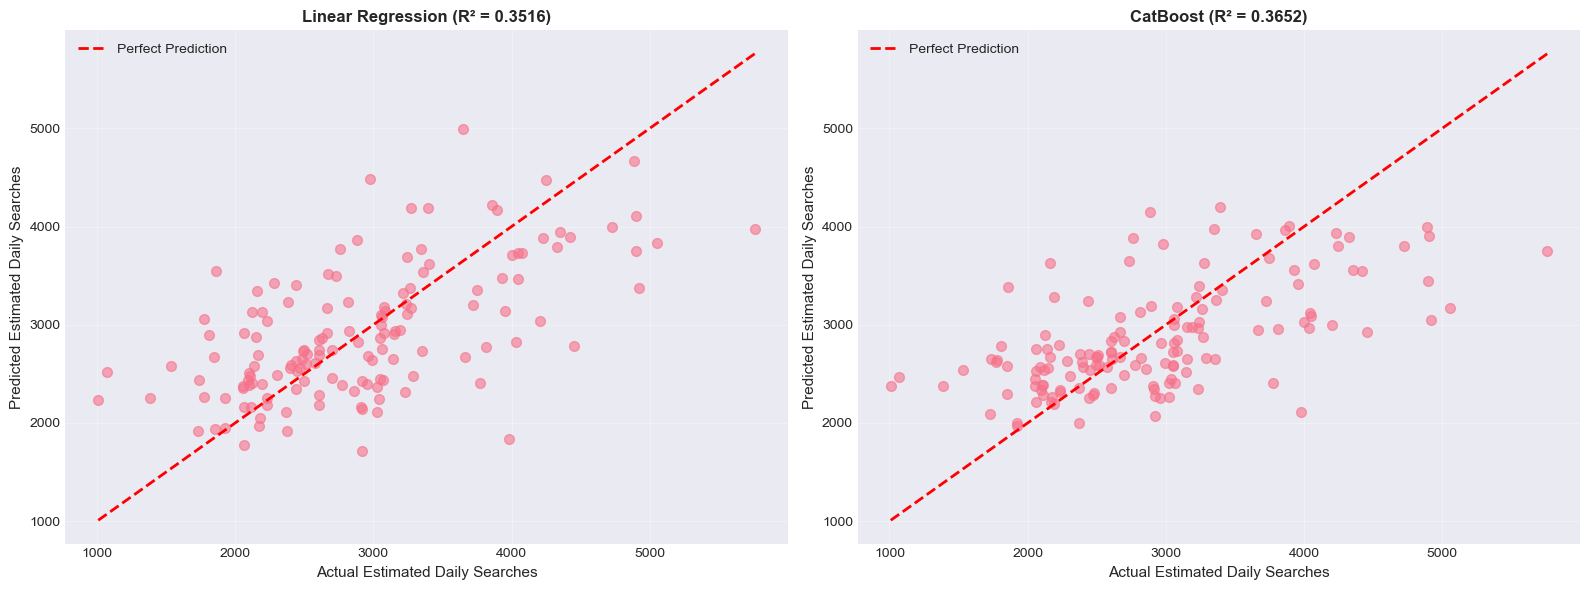

In [6]:
# 3. Scatter Plot Comparison
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Linear Regression
axes[0].scatter(y_test, y_pred_linear, alpha=0.6, s=50)
axes[0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', linewidth=2, label='Perfect Prediction')
axes[0].set_xlabel('Actual Estimated Daily Searches', fontsize=11)
axes[0].set_ylabel('Predicted Estimated Daily Searches', fontsize=11)
axes[0].set_title(f'Linear Regression (R² = {linear_results["metrics"]["R²"]:.4f})', fontsize=12, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# CatBoost
axes[1].scatter(y_test, y_pred_catboost, alpha=0.6, s=50)
axes[1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', linewidth=2, label='Perfect Prediction')
axes[1].set_xlabel('Actual Estimated Daily Searches', fontsize=11)
axes[1].set_ylabel('Predicted Estimated Daily Searches', fontsize=11)
axes[1].set_title(f'CatBoost (R² = {catboost_results["metrics"]["R²"]:.4f})', fontsize=12, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

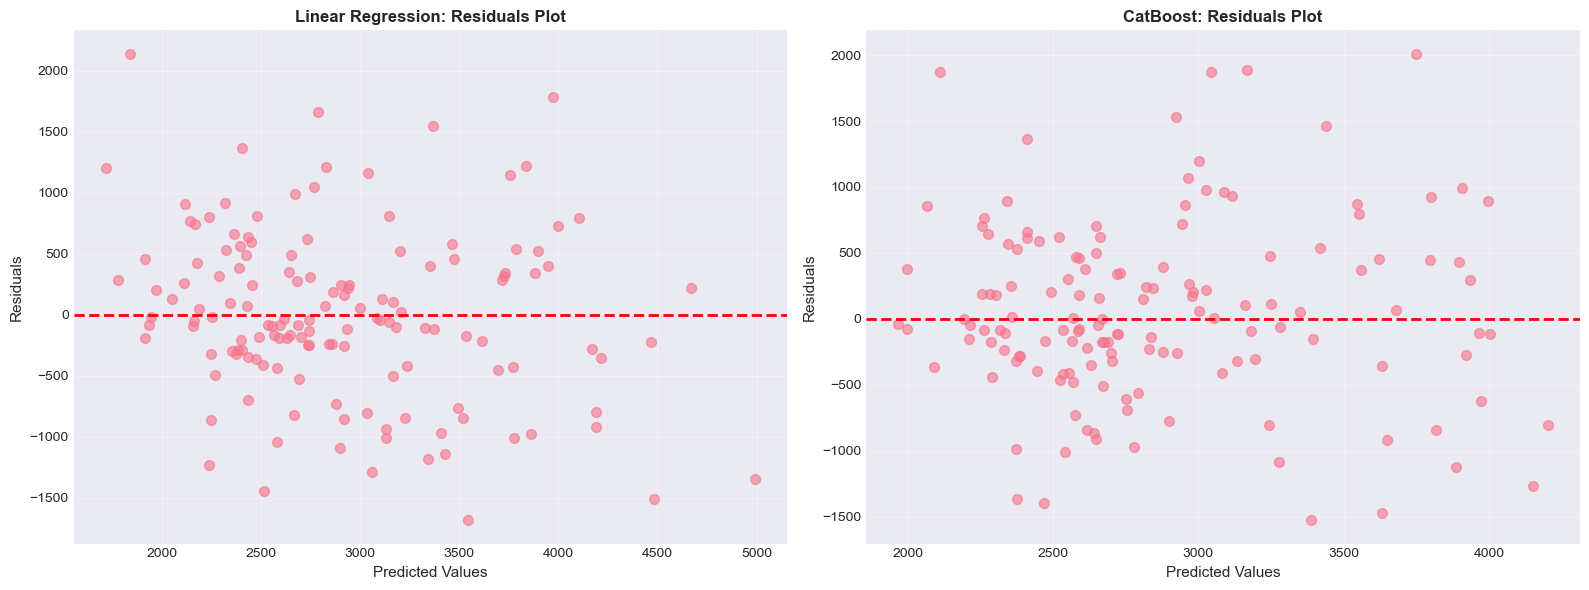

In [7]:
# 4. Residuals Comparison
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Linear Regression residuals
residuals_linear = y_test - y_pred_linear
axes[0].scatter(y_pred_linear, residuals_linear, alpha=0.6, s=50)
axes[0].axhline(y=0, color='r', linestyle='--', linewidth=2)
axes[0].set_xlabel('Predicted Values', fontsize=11)
axes[0].set_ylabel('Residuals', fontsize=11)
axes[0].set_title('Linear Regression: Residuals Plot', fontsize=12, fontweight='bold')
axes[0].grid(True, alpha=0.3)

# CatBoost residuals
residuals_catboost = y_test - y_pred_catboost
axes[1].scatter(y_pred_catboost, residuals_catboost, alpha=0.6, s=50)
axes[1].axhline(y=0, color='r', linestyle='--', linewidth=2)
axes[1].set_xlabel('Predicted Values', fontsize=11)
axes[1].set_ylabel('Residuals', fontsize=11)
axes[1].set_title('CatBoost: Residuals Plot', fontsize=12, fontweight='bold')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 4. Summary

In [8]:
# Determine best model
best_model = results_df['R²'].idxmax()
print("=" * 60)
print("SUMMARY")
print("=" * 60)
print(f"\nBest Model: {best_model}")
print(f"  R²: {results_df.loc[best_model, 'R²']:.4f}")
print(f"  RMSE: {results_df.loc[best_model, 'RMSE']:.2f}")
print(f"  MAE: {results_df.loc[best_model, 'MAE']:.2f}")
print(f"  MAPE: {results_df.loc[best_model, 'MAPE']:.2f}%")
print("\n" + "=" * 60)
print("\nKey Insights:")
print(f"  • Linear Regression provides interpretable coefficients")
print(f"  • CatBoost captures non-linear relationships better")
print(f"  • Both models show similar performance on this dataset")
print(f"  • Use CatBoost for better predictions, Linear Regression for interpretability")

SUMMARY

Best Model: CatBoost
  R²: 0.3652
  RMSE: 684.56
  MAE: 520.73
  MAPE: 19.29%


Key Insights:
  • Linear Regression provides interpretable coefficients
  • CatBoost captures non-linear relationships better
  • Both models show similar performance on this dataset
  • Use CatBoost for better predictions, Linear Regression for interpretability
